# Fermi 2nd Order acceleration


This code simulates the acceleration of particles assuming the second-order Fermi acceleration (toy) model.
The treatment is simplified, adopting quasi-linear theory for scattering off magnetic irregularities.

We first setup use the tools provided by CRPropa to understand particle acceleration, for several values of $\beta$.
This is not a streamlined regular simulation, which would be set up in a slightly different way.

In [ ]:

import numpy as np
from crpropa import *



def accelerate(beta, E0 = 1 * PeV, N = 2000, R = 10 * parsec):
	"""
	Accelerate a particle with a given beta and energy using the SecondOrderFermi acceleration model.

	# Inputs
	- beta: the velocity of the particle in units of c
	- E0: the initial energy of the particle [J]
	- N: the number of particles to simulate
	- R:  size of the acceleration region [m]
	"""
	acceleration = SecondOrderFermi(beta * c_light, R)

	angles = np.zeros(N)
	energyGain = np.zeros(N)

	scatterVelocityX = np.zeros(N)
	scatterVelocityY = np.zeros(N)
	scatterVelocityZ = np.zeros(N)

	for i in range(N):
		candidate = Candidate()
		candidate.current.setDirection(Vector3d(0, 0, 1.))
		candidate.current.setEnergy(E0)

		vs = acceleration.scatterCenterVelocity(candidate)
		scatterVelocityX[i] = vs.x
		scatterVelocityY[i] = vs.y
		scatterVelocityZ[i] = vs.z

		alpha = vs.getAngleTo(candidate.current.getDirection())
		angles[i] = alpha

		acceleration.scatter(candidate, vs)
		energyGain[i] = candidate.current.getEnergy() / E0

	res = {}
	res['theta'] = angles
	res['DeltaE/E'] = energyGain
	res['vX'] = scatterVelocityX
	res['vY'] = scatterVelocityY
	res['vZ'] = scatterVelocityZ

	return res


We now get all the properties of the simulated acceleration.
In particular, the function `accelerate` returns a dictionary with the following keys:
- `theta`: the scattering angle
- `DeltaE/E`: the energy gain
- `vX`: the x-component of the velocity
- `vY`: the y-component of the velocity
- `vZ`: the z-component of the velocity

In [2]:
betas = np.array([0.01, 0.1, 0.2, 0.3, 0.4, .5, .6, .7, .8, .9])
accelerated = {}
for beta in betas:
	accelerated[beta] =  accelerate(beta)

### Plotting

We create a function that makes a plot characterising the acceleration process for a given value of β.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline



def plotAll(beta):
	acc = accelerated[beta]

	fig = plt.figure(figsize = (6, 6), constrained_layout = True)
	grid = GridSpec(2, 2, figure = fig, bottom = 0.1, top = 0.9, left = 0.1, right = 0.9)

	ax1 = fig.add_subplot(grid[0, 0])
	ax2 = fig.add_subplot(grid[0, 1])
	ax3 = fig.add_subplot(grid[1, 0])
	ax4 = fig.add_subplot(grid[1, 1])


	ax1.hist(acc['vX'] / c_light, bins = 50, label = 'X', histtype = 'step')
	ax1.hist(acc['vY'] / c_light, bins = 50, label = 'Y', histtype = 'step')
	ax1.hist(acc['vZ'] / c_light, bins = 50, label = 'Z', histtype = 'step')
	ax1.set_xlabel('$\\beta$')
	ax1.legend()

	ax2.hist(acc['theta'] / deg, bins = 50)
	ax2.set_xlabel('$\\theta$ [$^\\circ$]')

	ax3.hist(acc['DeltaE/E'], bins = 50)
	ax3.set_xlabel('$\\dfrac{\\Delta E}{E}$')
	ax3.axvline(np.mean(acc['DeltaE/E']), ls = '--', color = 'k', label = 'mean')
	ax3.legend()

	ax4.hist2d(acc['theta'] / deg, acc['DeltaE/E'], bins = 100)
	ax4.set_xlabel('$\\theta$ [$^\\circ$]')
	ax4.set_ylabel('$\\dfrac{\\Delta E}{E}$')



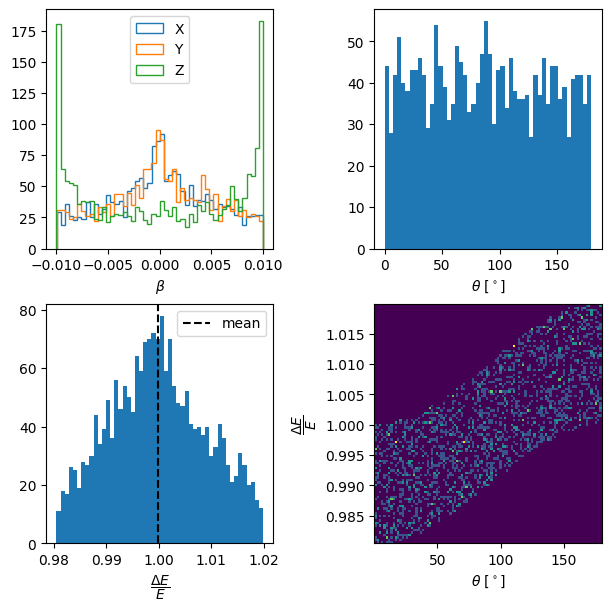

In [4]:
plotAll(0.01)

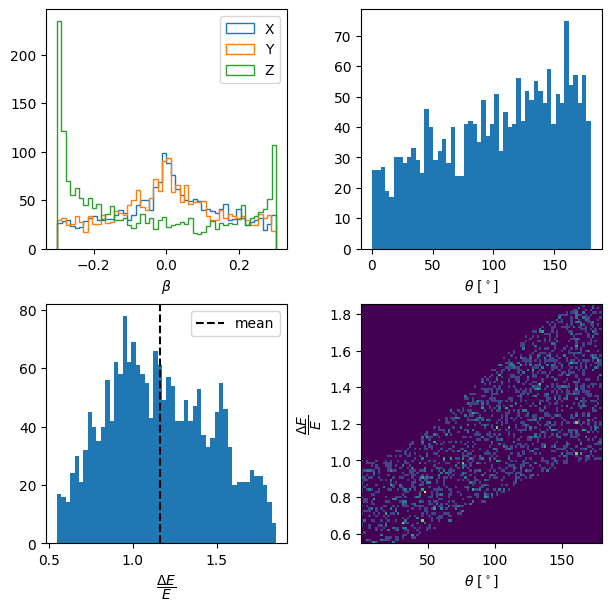

In [5]:
plotAll(0.3)

The average energy gain should depend on β². Let's make sure of that.

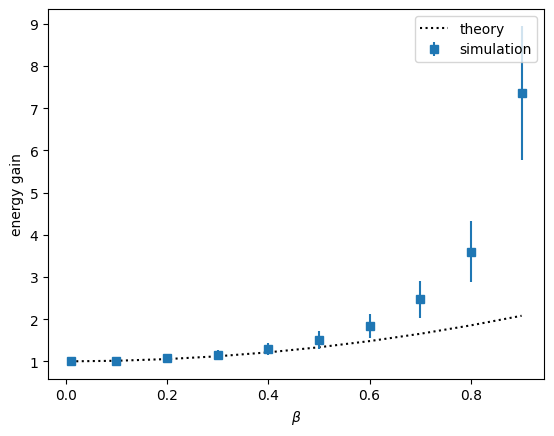

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)

# theoretical
dE_E = 1. + 4. / 3. * betas ** 2
ax.plot(betas, dE_E, label = 'theory', color = 'k', ls = ':')

# simulation
gainAvg = np.zeros(len(betas))
gainStd = np.zeros(len(betas))
for i, beta in enumerate(betas):
	gainAvg[i] = np.mean(accelerated[beta]['DeltaE/E'])
	gainStd[i] = np.std(accelerated[beta]['DeltaE/E'])

ax.errorbar(betas, gainAvg, yerr = gainStd / np.sqrt(len(betas)), ls = 'None', marker = 's', label = 'simulation')
ax.set_xlabel('$\\beta$')
ax.set_ylabel('energy gain')
ax.legend()
